<a href="https://colab.research.google.com/github/CamiSilvae/PDI/blob/main/ClaseOrdinaria/ExamenOrd/Ejercicio3/ORD_EJ3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXAMEN ORDINARIO

Camila Andrea Silva Espinoza (2109522)

---

**EJERCICIO 3: Convolución, gradientes y clasificación de bordes**

1. Carga de librerias y de imagen

En esta celda importamos las librerías necesarias y subimos la imagen usando files.upload(). Convertimos la imagen a escala de grises y la normalizamos a rango [0,1]. Además, mostramos la imagen original para verificar que se cargó correctamente. Si la imagen es muy grande, recomiendo redimensionarla aquí para agilizar el procesamiento

Saving Ejercicio3.jpg to Ejercicio3.jpg


(np.float64(-0.5), np.float64(470.5), np.float64(304.5), np.float64(-0.5))

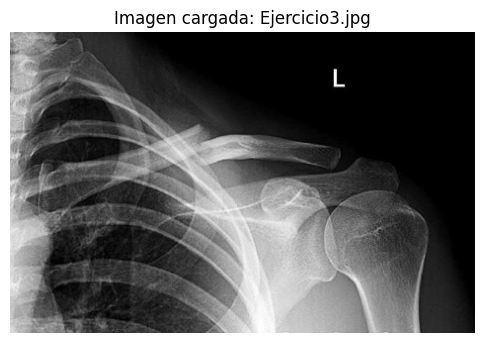

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab import files
from scipy import ndimage as ndi
from skimage import filters, measure, morphology, feature, util
import pandas as pd
import math

uploaded = files.upload()
image_name = list(uploaded.keys())[0]

img_color = cv2.imread(image_name, cv2.IMREAD_COLOR)
if img_color is None:
    raise ValueError("No fue posible leer la imagen. Verifica el archivo.")
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
img = img_gray.astype(np.float32) / 255.0

plt.figure(figsize=(6,6))
plt.title(f"Imagen cargada: {image_name}")
plt.imshow(img, cmap='gray')
plt.axis('off')


2. Aplicación de Sobel X y Y, Magnitud

Se aplicaron filtros Sobel en X y Y para estimar la componente horizontal y vertical del gradiente, luego calculamos la magnitud del gradiente. Mostramos Sobel X, Sobel Y y la magnitud (normalizadas) para visualización. Usaremos la magnitud para detectar bordes por Sobel.

(np.float64(-0.5), np.float64(470.5), np.float64(304.5), np.float64(-0.5))

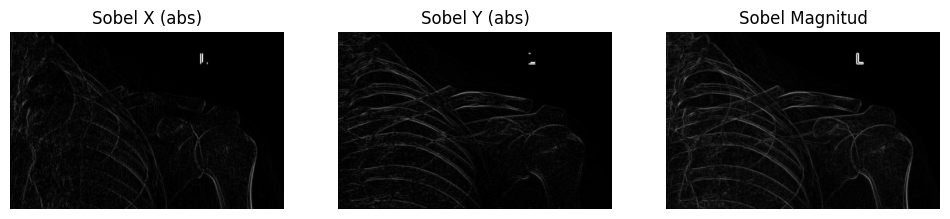

In [2]:
sobelx = cv2.Sobel((img*255).astype(np.float32), cv2.CV_32F, 1, 0, ksize=3)
sobely = cv2.Sobel((img*255).astype(np.float32), cv2.CV_32F, 0, 1, ksize=3)
sobel_mag = np.sqrt(sobelx**2 + sobely**2)

def norm01(a):
    a = a - a.min()
    if a.max() > 0:
        a = a / a.max()
    return a

sobelx_n = norm01(np.abs(sobelx))
sobely_n = norm01(np.abs(sobely))
sobel_mag_n = norm01(sobel_mag)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title('Sobel X (abs)'); plt.imshow(sobelx_n, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('Sobel Y (abs)'); plt.imshow(sobely_n, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Sobel Magnitud'); plt.imshow(sobel_mag_n, cmap='gray'); plt.axis('off')


3. Aplicación Lapciano y LoG

Se aplicó el perador Laplaciano y el Laplacian of Gaussian (LoG). Laplaciano detecta cambios de segunda derivada (bordes/inflecciones); LoG combina suavizado con detección de cruces por cero — útil para bordes finos. Mostramos imágenes resultantes y la versión de LoG procesada con detección de cruces por cero.

(np.float64(-0.5), np.float64(470.5), np.float64(304.5), np.float64(-0.5))

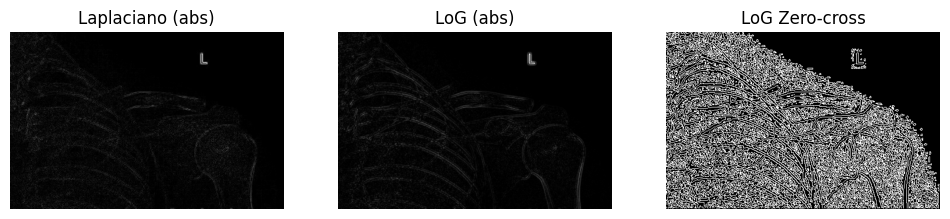

In [3]:
lap = cv2.Laplacian((img*255).astype(np.float32), cv2.CV_32F, ksize=3)
lap_n = norm01(np.abs(lap))

sigma_log = 1.0
img_blur_log = cv2.GaussianBlur(img, (0,0), sigmaX=sigma_log, sigmaY=sigma_log)
lap_log = cv2.Laplacian((img_blur_log*255).astype(np.float32), cv2.CV_32F, ksize=3)
lap_log_n = norm01(np.abs(lap_log))

zero_cross = np.zeros_like(lap_log, dtype=np.uint8)
th_zc = 0.01
rows, cols = lap_log.shape
for r in range(rows-1):
    for c in range(cols-1):
        p = lap_log[r,c]
        if (p > 0 and lap_log[r+1,c] < 0 or p < 0 and lap_log[r+1,c] > 0) and abs(p - lap_log[r+1,c]) > th_zc:
            zero_cross[r,c] = 255
        elif (p > 0 and lap_log[r,c+1] < 0 or p < 0 and lap_log[r,c+1] > 0) and abs(p - lap_log[r,c+1]) > th_zc:
            zero_cross[r,c] = 255

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title('Laplaciano (abs)'); plt.imshow(lap_n, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('LoG (abs)'); plt.imshow(lap_log_n, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title('LoG Zero-cross'); plt.imshow(zero_cross, cmap='gray'); plt.axis('off')


4. Obtención del gradiente morfológico completo

Se destaca contornos gruesos y es útil para visualizar perimetría. Se calcula el gradiente morfológico de la imagen (usando elemento estructurante elíptico) y se muestra.

(np.float64(-0.5), np.float64(470.5), np.float64(304.5), np.float64(-0.5))

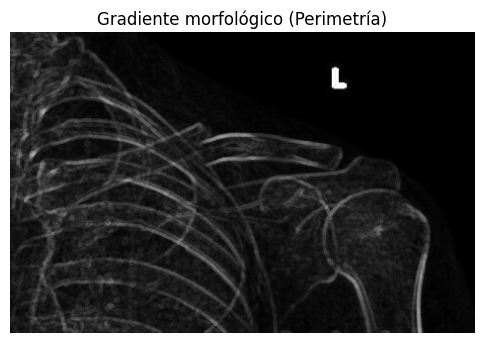

In [4]:
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
dilat = cv2.dilate((img*255).astype(np.uint8), se)
erod = cv2.erode((img*255).astype(np.uint8), se)
morph_grad = cv2.subtract(dilat, erod)
morph_grad_n = norm01(morph_grad.astype(np.float32))

plt.figure(figsize=(6,6))
plt.title('Gradiente morfológico (Perimetría)')
plt.imshow(morph_grad_n, cmap='gray')
plt.axis('off')


5. Extracción de borden binarios para cada operador

A partir de las salidas anteriores, binarizamos para obtener mapas de bordes por operador: Sobel (magnitud), Laplaciano (abs) y LoG (zero-cross). Usamos umbrales automáticos basados en percentiles/adaptativos para cada operador. También se extrae contornos con findContours para cada mapa de bordes; trabajaremos con esos contornos en la clasificación.

In [5]:
def binary_from_map(mapf, low_pct=85):
    thr = np.percentile(mapf, low_pct)
    bw = (mapf >= thr).astype(np.uint8) * 255
    return bw

sobel_bin = binary_from_map(sobel_mag_n, low_pct=90)
lap_bin = binary_from_map(lap_n, low_pct=90)
log_bin = zero_cross.copy()

morph_bin = binary_from_map(morph_grad_n, low_pct=85)

def get_contours_from_binary(bw):
    contours, _ = cv2.findContours(bw.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours

contours_sobel = get_contours_from_binary(sobel_bin)
contours_lap = get_contours_from_binary(lap_bin)
contours_log = get_contours_from_binary(log_bin)
contours_morph = get_contours_from_binary(morph_bin)

print(f"Contornos detectados Sobel: {len(contours_sobel)}, Lap: {len(contours_lap)}, LoG: {len(contours_log)}, Morph: {len(contours_morph)}")


Contornos detectados Sobel: 715, Lap: 3028, LoG: 68, Morph: 202


6. Clasificación de bordes (fractura, anatómico y ruido)

Se define una clasificación basada en propiedades de cada contorno:

* Longitud (arc length): contornos muy cortos → ruido.

* Magnitud media del gradiente sobre el contorno: fracturas suelen tener gradientes grandes y rugosos.

* Linealidad / rectangularidad /aspect ratio: fracturas suelen ser líneas relativamente largas y estrechas (alto aspect ratio) y con curvaturas irregulares; bordes anatómicos suelen ser más continuos y suaves (mayor longitud y mayor continuidad).

* Solidity / extent: contornos compactos (alta solidity) tienden a ser ruido o manchas; fracturas son alargadas (baja solidity).

Se implementan estas medidas, aplicamos reglas y devolvemos etiquetas. Los umbrales son iniciales y pueden ajustarse según la imagen.

In [13]:
def contour_length(c):

    try:
        return float(cv2.arcLength(c.astype(np.float32), closed=False))
    except Exception:
        return 0.0

def _contour_to_xy(c):

    pts = np.array(c)

    pts = np.squeeze(pts)
    if pts.ndim == 1:

        if pts.size == 2:
            coords = pts.reshape(1,2)
        else:
            coords = np.empty((0,2), dtype=int)
    elif pts.ndim == 2 and pts.shape[1] == 2:
        coords = pts
    elif pts.ndim == 2 and pts.shape[1] == 1:

        coords = pts[:,0].reshape(-1,2) if pts[:,0].size % 2 == 0 else pts[:,0]
    else:

        coords = pts.reshape(-1, 2)

    coords = coords.astype(int)
    return coords

def contour_mean_gradient(c, grad_mag):
    coords = _contour_to_xy(c)
    if coords.size == 0:
        return 0.0
    vals = []
    h, w = grad_mag.shape
    for (x, y) in coords:

        xi = int(np.clip(x, 0, w - 1))
        yi = int(np.clip(y, 0, h - 1))
        vals.append(float(grad_mag[yi, xi]))
    return float(np.mean(vals)) if len(vals) > 0 else 0.0

def contour_bounding_props(c):

    coords = _contour_to_xy(c)
    if coords.size == 0:
        return {'area': 0.0, 'bbox_area': 1.0, 'aspect': 1.0, 'extent': 0.0}

    try:
        x, y, w, h = cv2.boundingRect(coords.reshape(-1,1,2).astype(np.int32))
    except Exception:

        xs = coords[:,0]
        ys = coords[:,1]
        x, y, w, h = int(xs.min()), int(ys.min()), int(xs.max()-xs.min()+1), int(ys.max()-ys.min()+1)
    area = cv2.contourArea(coords.reshape(-1,1,2).astype(np.int32))
    bbox_area = float(max(1, w*h))
    aspect = float(max(w/h, h/w)) if min(w,h) > 0 else 1.0
    extent = float(area / bbox_area) if bbox_area > 0 else 0.0
    return {'area': area, 'bbox_area': bbox_area, 'aspect': aspect, 'extent': extent}

def classify_contours(contours, grad_mag_map, min_len=30, grad_thresh=0.15, aspect_thresh=2.5, extent_thresh=0.3):
    results = []
    for c in contours:
        L = contour_length(c)
        mean_g = contour_mean_gradient(c, grad_mag_map)
        props = contour_bounding_props(c)
        extent = props['extent']
        aspect = props['aspect']
        area = props['area']

        if L < min_len and mean_g < grad_thresh:
            label = 'noise'
        elif L >= min_len and (mean_g >= grad_thresh) and (aspect >= aspect_thresh or extent <= extent_thresh):
            label = 'fracture'
        else:
            label = 'anatomical'

        results.append({
            'contour': c,
            'label': label,
            'length': L,
            'mean_grad': mean_g,
            'aspect': aspect,
            'extent': extent,
            'area': area
        })
    return results

grad_map_for_class = sobel_mag_n

res_sobel = classify_contours(contours_sobel, grad_map_for_class, min_len=25, grad_thresh=0.12, aspect_thresh=2.5, extent_thresh=0.35)
res_lap = classify_contours(contours_lap, grad_map_for_class, min_len=20, grad_thresh=0.10, aspect_thresh=2.2, extent_thresh=0.35)
res_log = classify_contours(contours_log, grad_map_for_class, min_len=15, grad_thresh=0.08, aspect_thresh=2.0, extent_thresh=0.4)
res_morph = classify_contours(contours_morph, grad_map_for_class, min_len=20, grad_thresh=0.10, aspect_thresh=2.2, extent_thresh=0.35)

from collections import Counter
def count_labels(res):
    labels = [r['label'] for r in res]
    return Counter(labels)

print("Conteo labels por operador:")
print("Sobel:", count_labels(res_sobel))
print("Laplaciano:", count_labels(res_lap))
print("LoG:", count_labels(res_log))
print("Morph Grad:", count_labels(res_morph))


Conteo labels por operador:
Sobel: Counter({'noise': 436, 'anatomical': 222, 'fracture': 57})
Laplaciano: Counter({'noise': 2526, 'anatomical': 428, 'fracture': 74})
LoG: Counter({'noise': 53, 'anatomical': 13, 'fracture': 2})
Morph Grad: Counter({'noise': 120, 'anatomical': 81, 'fracture': 1})


7. Visualización y color de contornos clasificados

Se superponen contornos clasificados sobre la imagen original con colores: rojo = fractura, verde = anatómico, azul = ruido. Visualizamos por operador y también una tabla resumen con conteos para facilitar comparaciones.

Resumen (número de contornos etiquetados por clase y operador):


,fracture,anatomical,noise
fracture,1.0,NaN,NaN
anatomical,NaN,81.0,NaN
noise,NaN,NaN,120.0


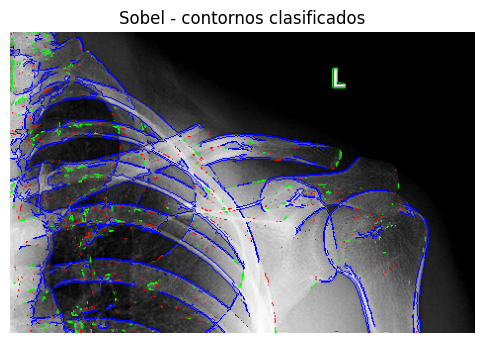

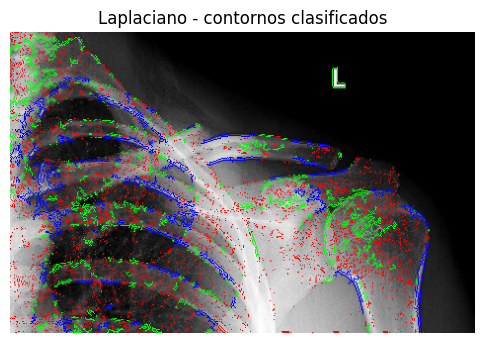

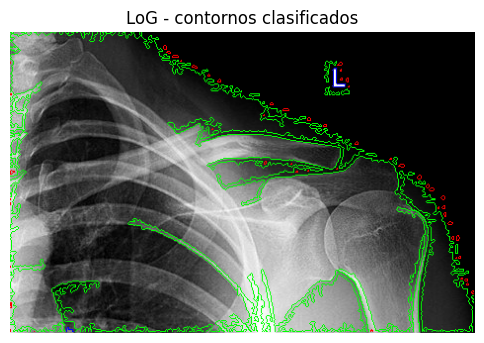

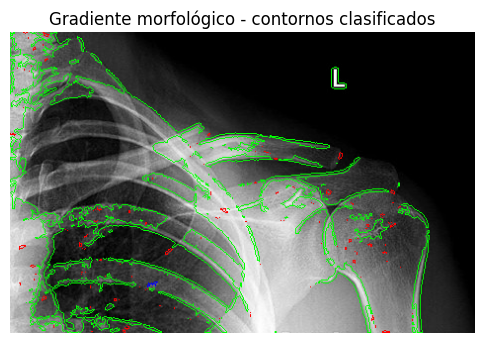

In [14]:
def overlay_classified(cont_results, title):
    overlay = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    for r in cont_results:
        c = r['contour']
        lab = r['label']
        if lab == 'fracture':
            color = (255,0,0)
        elif lab == 'anatomical':
            color = (0,255,0)
        else:
            color = (0,0,255)
        cv2.drawContours(overlay, [c], -1, color, 1)
    plt.figure(figsize=(6,6))
    plt.title(title)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')

overlay_classified(res_sobel, "Sobel - contornos clasificados")
overlay_classified(res_lap, "Laplaciano - contornos clasificados")
overlay_classified(res_log, "LoG - contornos clasificados")
overlay_classified(res_morph, "Gradiente morfológico - contornos clasificados")

from collections import Counter
summary = {
    'Sobel': count_labels(res_sobel),
    'Laplaciano': count_labels(res_lap),
    'LoG': count_labels(res_log),
    'MorphGrad': count_labels(res_morph)
}
df_summary = pd.DataFrame([{k:summary[op].get(k,0) for op in summary} for k in ['fracture','anatomical','noise']], index=['fracture','anatomical','noise'])
df_summary = df_summary.T
print("Resumen (número de contornos etiquetados por clase y operador):")
display(df_summary)


8. Identificación del mejor operador para detectar la fractura

Contamos cuántos contornos etiquetados como fracture detectó cada operador. Decimos que el operador que detectó más contornos clasificados como fracture es el que según la heurística detectó mejorlas fracturas.

In [15]:
fracture_counts = {
    'Sobel': count_labels(res_sobel).get('fracture',0),
    'Laplaciano': count_labels(res_lap).get('fracture',0),
    'LoG': count_labels(res_log).get('fracture',0),
    'MorphGrad': count_labels(res_morph).get('fracture',0)
}
print("Conteo de 'fracture' (heurístico) por operador:")
for k,v in fracture_counts.items():
    print(f" - {k}: {v}")

best_op = max(fracture_counts, key=fracture_counts.get)
print(f"\nSegún la heurística aplicada, el operador que detectó más fracturas es: {best_op}")



Conteo de 'fracture' (heurístico) por operador:
 - Sobel: 57
 - Laplaciano: 74
 - LoG: 2
 - MorphGrad: 1

Según la heurística aplicada, el operador que detectó más fracturas es: Laplaciano
